In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**We will try to reach the final solution through simple steps initially, Eventually we can proceed with the complex form of modelling.**

Load the necessary libraries 

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
#Load all the necessary libraries

import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
from tqdm import tqdm

from ast import literal_eval
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline

nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Ingest all the files.**

We have total of 5 files

In [8]:
# ingest all the input files

sample_sub=pd.read_csv("/content/drive/My Drive/NBME/NBME/sample_submission.csv")
patient_note=pd.read_csv("/content/drive/My Drive/NBME/NBME/patient_notes.csv")
features=pd.read_csv("/content/drive/My Drive/NBME/NBME/features.csv")
train=pd.read_csv("/content/drive/My Drive/NBME/NBME/train.csv")
test=pd.read_csv("/content/drive/My Drive/NBME/NBME/test.csv")
#../input/nmbe-test2


In [9]:
# The shape of the files

print("The shape of patient note table is : " + str(patient_note.shape))
print("The shape of feature table is : " + str(features.shape))
print("The shape of train table is : " + str(train.shape))
print("The shape of test table is : " + str(test.shape))
print("The shape of sample_sub table is : " + str(sample_sub.shape))


The shape of patient note table is : (42146, 3)
The shape of feature table is : (143, 3)
The shape of train table is : (14300, 6)
The shape of test table is : (5, 4)
The shape of sample_sub table is : (5, 2)


In [10]:
# check for missing values in each one of the files

print(sample_sub.isnull().sum())
sample_sub.head()

id          0
location    2
dtype: int64


,id,location
0,00016_000,0 100
1,00016_001,NaN
2,00016_002,200 250;300 400
3,00016_003,NaN
4,00016_004,75 110


In [11]:
print(patient_note.isnull().sum())
patient_note.head()

pn_num        0
case_num      0
pn_history    0
dtype: int64


,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


In [12]:
print(features.isnull().sum())
features.head()

feature_num     0
case_num        0
feature_text    0
dtype: int64


,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


In [13]:
print(train.isnull().sum())
train.head()

id             0
case_num       0
pn_num         0
feature_num    0
annotation     0
location       0
dtype: int64


,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


In [14]:
print(test.isnull().sum())
test.head()

id             0
case_num       0
pn_num         0
feature_num    0
dtype: int64


,id,case_num,pn_num,feature_num
0,00016_000,0,16,0
1,00016_001,0,16,1
2,00016_002,0,16,2
3,00016_003,0,16,3
4,00016_004,0,16,4


In [15]:
# Check if the data present in the files are unique at a particular column

print(patient_note['pn_num'].duplicated(keep='last').sum())
print(features['feature_num'].duplicated(keep='last').sum())
print(train[['pn_num','feature_num']].duplicated(keep='last').sum())
print(test[['case_num','pn_num','feature_num']].duplicated(keep='last').sum())

0
0
0
0


In [16]:
features['case_num'].value_counts()

5    18
8    18
2    17
9    17
3    16
0    13
1    13
6    12
4    10
7     9
Name: case_num, dtype: int64

Till now we have seen that we have a train file in which we can find the annotation and location column which seems to be the column we need to predict. Theoritically these are tags or key phrases from patient notes and probably these tags should be enough to provide the current status of the patient.

**Also most of the tags have only one key phrase, Although there are about 3 with 10 key phrases**

In [17]:
# Prepare your training file by joining all the necessary columns from other tables

df_1 = pd.merge(train, patient_note, left_on='pn_num', right_on='pn_num', how='left')
df_1=pd.merge(df_1, features, left_on=['case_num_x','feature_num'], right_on=['case_num','feature_num'], how='left')

In [18]:
# Prepare your test file by joining all the necessary columns from other tables

test_df_1 = pd.merge(test, patient_note, left_on='pn_num', right_on='pn_num', how='left')
test_df_1=pd.merge(test_df_1, features, left_on=['case_num_x','feature_num'], right_on=['case_num','feature_num'], how='left')

In [19]:
print(df_1.shape)
df_1.head()

(14300, 10)


,id,case_num_x,pn_num,feature_num,annotation,location,case_num_y,pn_history,case_num,feature_text
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],0,HPI: 17yo M presents with palpitations. Patien...,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],0,HPI: 17yo M presents with palpitations. Patien...,0,Family-history-of-thyroid-disorder
2,00016_002,0,16,2,['chest pressure'],['203 217'],0,HPI: 17yo M presents with palpitations. Patien...,0,Chest-pressure
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']",0,HPI: 17yo M presents with palpitations. Patien...,0,Intermittent-symptoms
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258'],0,HPI: 17yo M presents with palpitations. Patien...,0,Lightheaded


In [20]:
print(test_df_1.shape)
test_df_1.head()

(5, 8)


,id,case_num_x,pn_num,feature_num,case_num_y,pn_history,case_num,feature_text
0,00016_000,0,16,0,0,HPI: 17yo M presents with palpitations. Patien...,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,00016_001,0,16,1,0,HPI: 17yo M presents with palpitations. Patien...,0,Family-history-of-thyroid-disorder
2,00016_002,0,16,2,0,HPI: 17yo M presents with palpitations. Patien...,0,Chest-pressure
3,00016_003,0,16,3,0,HPI: 17yo M presents with palpitations. Patien...,0,Intermittent-symptoms
4,00016_004,0,16,4,0,HPI: 17yo M presents with palpitations. Patien...,0,Lightheaded


In [21]:
#Drop duplicated columns 
df2=df_1.drop(columns=['case_num_y','case_num_x'])

In [22]:
#Drop duplicated columns 
test_df2=test_df_1.drop(columns=['case_num_y','case_num_x'])

In [23]:
print(df2.shape)
df2.head()

(14300, 8)


,id,pn_num,feature_num,annotation,location,pn_history,case_num,feature_text
0,00016_000,16,0,['dad with recent heart attcak'],['696 724'],HPI: 17yo M presents with palpitations. Patien...,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,00016_001,16,1,"['mom with ""thyroid disease']",['668 693'],HPI: 17yo M presents with palpitations. Patien...,0,Family-history-of-thyroid-disorder
2,00016_002,16,2,['chest pressure'],['203 217'],HPI: 17yo M presents with palpitations. Patien...,0,Chest-pressure
3,00016_003,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']",HPI: 17yo M presents with palpitations. Patien...,0,Intermittent-symptoms
4,00016_004,16,4,['felt as if he were going to pass out'],['222 258'],HPI: 17yo M presents with palpitations. Patien...,0,Lightheaded


In [24]:
print(test_df2.shape)
test_df2.head()

(5, 6)


,id,pn_num,feature_num,pn_history,case_num,feature_text
0,00016_000,16,0,HPI: 17yo M presents with palpitations. Patien...,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,00016_001,16,1,HPI: 17yo M presents with palpitations. Patien...,0,Family-history-of-thyroid-disorder
2,00016_002,16,2,HPI: 17yo M presents with palpitations. Patien...,0,Chest-pressure
3,00016_003,16,3,HPI: 17yo M presents with palpitations. Patien...,0,Intermittent-symptoms
4,00016_004,16,4,HPI: 17yo M presents with palpitations. Patien...,0,Lightheaded


## Feature Extraction from text data
1. Number of words present in patient history

151    359
136    337
139    304
154    289
144    288
138    287
141    272
147    271
148    269
146    265
135    263
140    261
152    260
155    257
122    256
130    253
157    250
137    248
142    224
Name: pn_history, dtype: int64


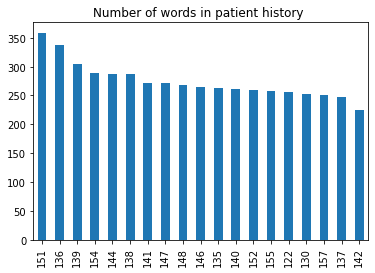

In [25]:
# Number of words present in patient history
word_count = df2['pn_history'].apply(lambda x: len(str(x).split(" ")))
k=word_count.value_counts().sort_values(ascending=False)[1:20]
print(k)

k.plot(kind="bar")
plt.title("Number of words in patient history ")
#plt.xlabel(“Number of Tags”)
#plt.ylabel(“Number of synopsis”)

plt.show()

2    2300
3     600
Name: feature_text, dtype: int64


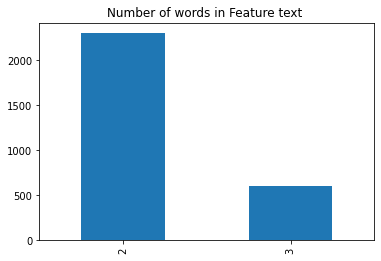

In [26]:
# Number of words present in patient history
word_count = df2['feature_text'].apply(lambda x: len(str(x).split("-OR-")))
k=word_count.value_counts().sort_values(ascending=False)[1:20]
print(k)

k.plot(kind="bar")
plt.title("Number of words in Feature text ")
#plt.xlabel(“Number of Tags”)
#plt.ylabel(“Number of synopsis”)

plt.show()

Most of the records havemore between 100-150 words in patient notes

1     12480
2      1345
3       309
4       114
5        35
6         7
7         4
8         3
10        3
Name: annotation, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


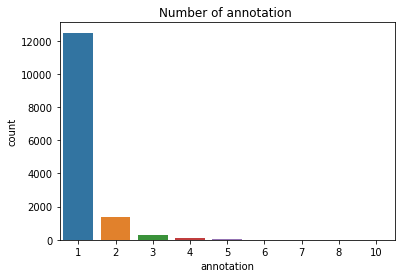

In [27]:
# Check the frequency of the count of tags

tags_count=df2.annotation.apply(lambda x: len(x.split(',')))
print(tags_count.value_counts())

sns.countplot(tags_count)
plt.title("Number of annotation ")
#plt.xlabel(“Number of Tags”)
#plt.ylabel(“Number of synopsis”)

plt.show()

## Text Pre-processing 

In [28]:
#Remove special characters but not spaces, here we are not removing comma or spaces from the data because we might need it later


df2['feature_text']=df2['feature_text'].str.replace("-OR-", "; ").str.replace("-", " ")
df2['annotation_dup']=df2['annotation']
df2['annotation']=df2['annotation'].str.replace(",", ';')
df2['annotation']=df2['annotation'].str.replace("'", '')
df2['annotation']=df2['annotation'].str.replace("[", '')
df2['annotation']=df2['annotation'].str.replace("]", '')
df2['pn_history']=df2['pn_history'].str.translate ({ord(c): " " for c in "!@#$%^&*()[]{}:,./<>?\|`~-=_+"})
df2['annotation']=df2['annotation'].str.translate ({ord(c): " " for c in "!@#$%^&*()[]{}:,./<>?\|`~-=_+"})

test_df2['feature_text']=test_df2['feature_text'].str.replace("-OR-", "; ").str.replace("-", " ")
test_df2['pn_history']=test_df2['pn_history'].str.translate ({ord(c): " " for c in "!@#$%^&*()[]{}:,./<>?\|`~-=_+"})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if __name__ == '__main__':


In [29]:
df2.head()

,id,pn_num,feature_num,annotation,location,pn_history,case_num,feature_text,annotation_dup
0,00016_000,16,0,dad with recent heart attcak,['696 724'],HPI 17yo M presents with palpitations Patien...,0,Family history of MI; Family history of myocar...,['dad with recent heart attcak']
1,00016_001,16,1,"mom with ""thyroid disease",['668 693'],HPI 17yo M presents with palpitations Patien...,0,Family history of thyroid disorder,"['mom with ""thyroid disease']"
2,00016_002,16,2,chest pressure,['203 217'],HPI 17yo M presents with palpitations Patien...,0,Chest pressure,['chest pressure']
3,00016_003,16,3,intermittent episodes; episode,"['70 91', '176 183']",HPI 17yo M presents with palpitations Patien...,0,Intermittent symptoms,"['intermittent episodes', 'episode']"
4,00016_004,16,4,felt as if he were going to pass out,['222 258'],HPI 17yo M presents with palpitations Patien...,0,Lightheaded,['felt as if he were going to pass out']


In [30]:
test_df2.head()

,id,pn_num,feature_num,pn_history,case_num,feature_text
0,00016_000,16,0,HPI 17yo M presents with palpitations Patien...,0,Family history of MI; Family history of myocar...
1,00016_001,16,1,HPI 17yo M presents with palpitations Patien...,0,Family history of thyroid disorder
2,00016_002,16,2,HPI 17yo M presents with palpitations Patien...,0,Chest pressure
3,00016_003,16,3,HPI 17yo M presents with palpitations Patien...,0,Intermittent symptoms
4,00016_004,16,4,HPI 17yo M presents with palpitations Patien...,0,Lightheaded


In [31]:
df2[['pn_history','feature_text','annotation']].head()

,pn_history,feature_text,annotation
0,HPI 17yo M presents with palpitations Patien...,Family history of MI; Family history of myocar...,dad with recent heart attcak
1,HPI 17yo M presents with palpitations Patien...,Family history of thyroid disorder,"mom with ""thyroid disease"
2,HPI 17yo M presents with palpitations Patien...,Chest pressure,chest pressure
3,HPI 17yo M presents with palpitations Patien...,Intermittent symptoms,intermittent episodes; episode
4,HPI 17yo M presents with palpitations Patien...,Lightheaded,felt as if he were going to pass out


In [32]:
test_df2[['pn_history','feature_text']].head()

,pn_history,feature_text
0,HPI 17yo M presents with palpitations Patien...,Family history of MI; Family history of myocar...
1,HPI 17yo M presents with palpitations Patien...,Family history of thyroid disorder
2,HPI 17yo M presents with palpitations Patien...,Chest pressure
3,HPI 17yo M presents with palpitations Patien...,Intermittent symptoms
4,HPI 17yo M presents with palpitations Patien...,Lightheaded


In [33]:
df2.dtypes

id                object
pn_num             int64
feature_num        int64
annotation        object
location          object
pn_history        object
case_num           int64
feature_text      object
annotation_dup    object
dtype: object

In [34]:
test_df2.dtypes

id              object
pn_num           int64
feature_num      int64
pn_history      object
case_num         int64
feature_text    object
dtype: object

In [35]:
# Find out if there are duplicates at data level in training file
print(len(df2.groupby(['pn_history','feature_text'])))
df2.shape

14300


(14300, 9)

In [36]:
# Find out if there are duplicates at data level in training file
print(len(test_df2.groupby(['pn_history','feature_text'])))
test_df2.shape

5


(5, 6)

In [37]:
# Convert data to lowercase

df2['pn_history']=df2['pn_history'].apply(lambda x: x.lower())
df2['feature_text']=df2['feature_text'].apply(lambda x: x.lower())
df2['annotation']=df2['annotation'].apply(lambda x: x.lower())

In [38]:
# Convert data to lowercase

test_df2['pn_history']=test_df2['pn_history'].apply(lambda x: x.lower())
test_df2['feature_text']=test_df2['feature_text'].apply(lambda x: x.lower())


In [39]:
df2.head()

,id,pn_num,feature_num,annotation,location,pn_history,case_num,feature_text,annotation_dup
0,00016_000,16,0,dad with recent heart attcak,['696 724'],hpi 17yo m presents with palpitations patien...,0,family history of mi; family history of myocar...,['dad with recent heart attcak']
1,00016_001,16,1,"mom with ""thyroid disease",['668 693'],hpi 17yo m presents with palpitations patien...,0,family history of thyroid disorder,"['mom with ""thyroid disease']"
2,00016_002,16,2,chest pressure,['203 217'],hpi 17yo m presents with palpitations patien...,0,chest pressure,['chest pressure']
3,00016_003,16,3,intermittent episodes; episode,"['70 91', '176 183']",hpi 17yo m presents with palpitations patien...,0,intermittent symptoms,"['intermittent episodes', 'episode']"
4,00016_004,16,4,felt as if he were going to pass out,['222 258'],hpi 17yo m presents with palpitations patien...,0,lightheaded,['felt as if he were going to pass out']


In [40]:
test_df2.head()

,id,pn_num,feature_num,pn_history,case_num,feature_text
0,00016_000,16,0,hpi 17yo m presents with palpitations patien...,0,family history of mi; family history of myocar...
1,00016_001,16,1,hpi 17yo m presents with palpitations patien...,0,family history of thyroid disorder
2,00016_002,16,2,hpi 17yo m presents with palpitations patien...,0,chest pressure
3,00016_003,16,3,hpi 17yo m presents with palpitations patien...,0,intermittent symptoms
4,00016_004,16,4,hpi 17yo m presents with palpitations patien...,0,lightheaded


In [41]:
# Check if there are duplicate annotaions in the file
print(len(df2.groupby(['annotation'])))
df2.shape


4732


(14300, 9)

### The annotaion are repeating itself, The below plot will provide the frequency of the  top 30 annotions

                                     4399
f                                     353
female                                226
m                                     151
nausea                                120
                                     ... 
feels bloated when eating               1
pain worsening                          1
pain now wakes him at night             1
tums was working but now does not       1
photobia                                1
Name: annotation, Length: 4732, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only
  import sys


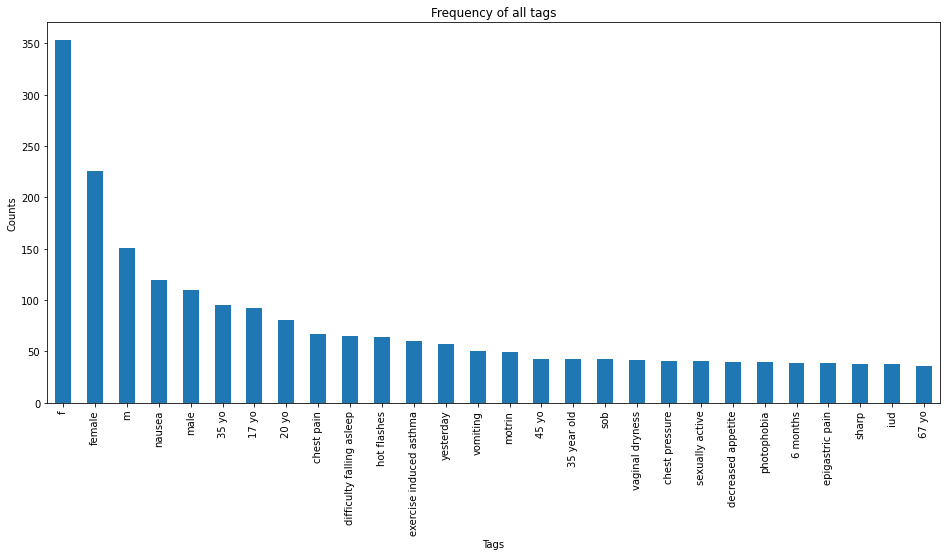

In [42]:
# Check the frequency of the count of tags

#tags_count=df2.annotation.apply(lambda x: len(x.split(',')))
#avc
print(df2.annotation.value_counts())

sorted_freq_df=df2.annotation.value_counts().sort_values(0, ascending=False)[1:30]
sorted_freq_df.head(-1).plot(kind="bar", figsize=(16,7), legend=False)
i=np.arange(71)
plt.title("Frequency of all tags")
plt.xlabel("Tags")
plt.ylabel("Counts")
plt.show()

female                                 700
male                                   300
20 year                                200
nausea                                 200
35 year                                200
                                      ... 
44 year                                100
sleep disturbance; early awakenings    100
heavy sweating                         100
onset 3 years ago                      100
subjective fever                       100
Name: feature_text, Length: 131, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only
  import sys


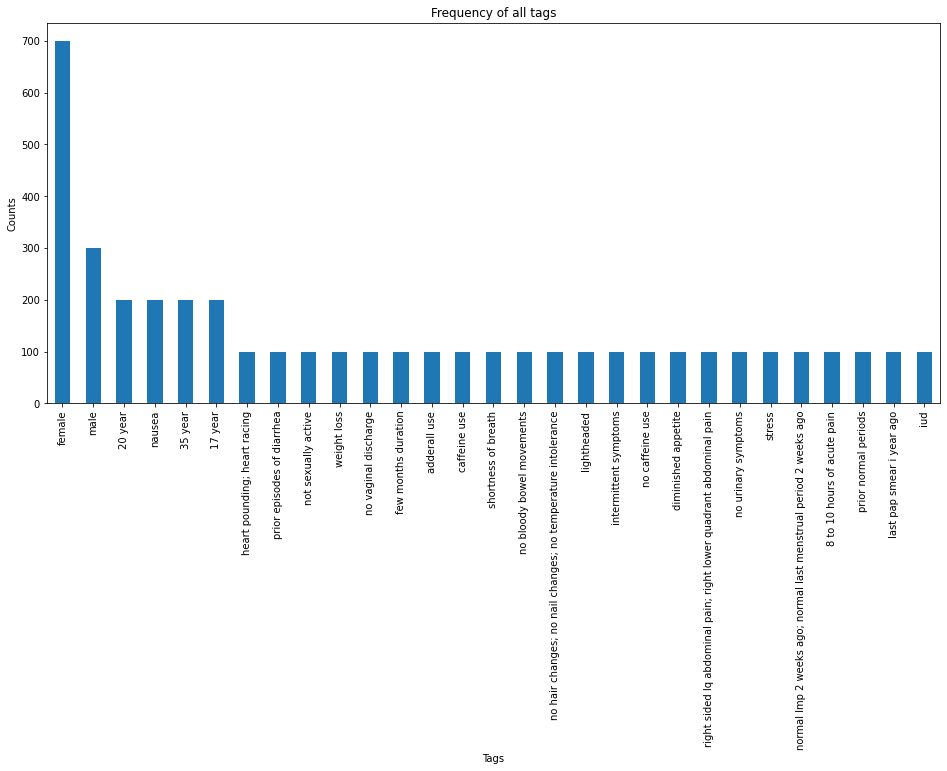

In [43]:
# Check the frequency of the count of tags

#tags_count=df2.annotation.apply(lambda x: len(x.split(',')))
#avc
print(df2.feature_text.value_counts())

sorted_freq_df=df2.feature_text.value_counts().sort_values(0, ascending=False)[0:30]
sorted_freq_df.head(-1).plot(kind="bar", figsize=(16,7), legend=False)
i=np.arange(71)
plt.title("Frequency of all tags")
plt.xlabel("Tags")
plt.ylabel("Counts")
plt.show()

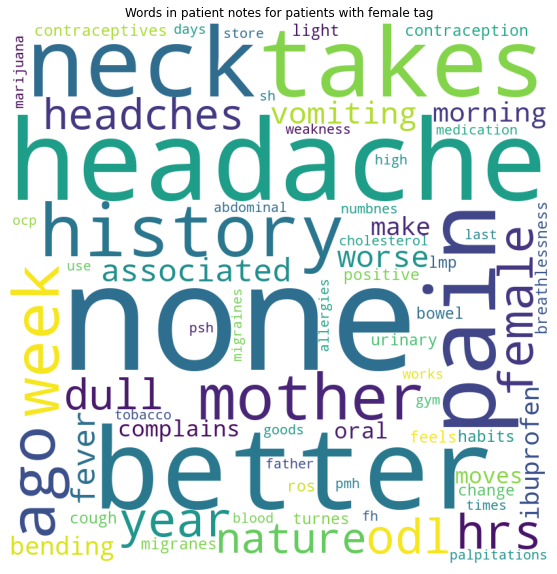

In [44]:
# Creating a column to indicate whether a female tag exists and its connection with other words preesnt in the patient history
df2["tags_female"]= [1 if "female" in tgs.split(';') else 0 for tgs in df2.annotation]

# creating a corpus for movies with female tag
female_word_cloud=""
for pn_hist in df2[df2["tags_female"]==1].pn_history:
    female_word_cloud = pn_hist + " "

from wordcloud import WordCloud

#building a wordcloud
wordcloud = WordCloud(width=800, height=800, collocations=False,
background_color="white").generate(female_word_cloud)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.title("Words in patient notes for patients with female tag")
plt.axis("off")
plt.show()

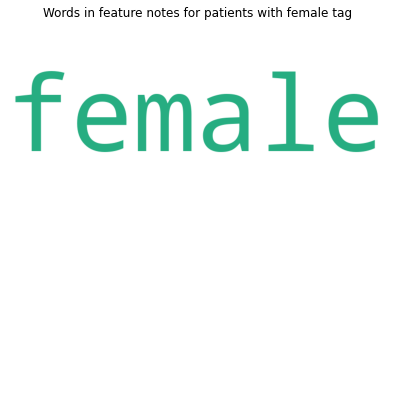

In [45]:
# Creating a column to indicate whether a female tag exists and its connection with other words preesnt in the feature column
df2["tags_female"]= [1 if "female" in tgs.split(';') else 0 for tgs in df2.annotation]

# creating a corpus for movies with female tag
female_word_cloud=""
for feature in df2[df2["tags_female"]==1].feature_text:
    female_word_cloud = feature + " "

from wordcloud import WordCloud

#building a wordcloud
wordcloud = WordCloud(width=800, height=800, collocations=False,
background_color="white").generate(female_word_cloud)

plt.figure(figsize=(7,7))
plt.imshow(wordcloud)
plt.title("Words in feature notes for patients with female tag")
plt.axis("off")
plt.show()

In [46]:
df2[df2["annotation"]==""].head()

,id,pn_num,feature_num,annotation,location,pn_history,case_num,feature_text,annotation_dup,tags_female
5,00016_005,16,5,,[],hpi 17yo m presents with palpitations patien...,0,no hair changes; no nail changes; no temperatu...,[],0
7,00016_007,16,7,,[],hpi 17yo m presents with palpitations patien...,0,shortness of breath,[],0
8,00016_008,16,8,,[],hpi 17yo m presents with palpitations patien...,0,caffeine use,[],0
13,00041_000,41,0,,[],17 y o m came to the clinic c o heart pounding...,0,family history of mi; family history of myocar...,[],0
17,00041_004,41,4,,[],17 y o m came to the clinic c o heart pounding...,0,lightheaded,[],0


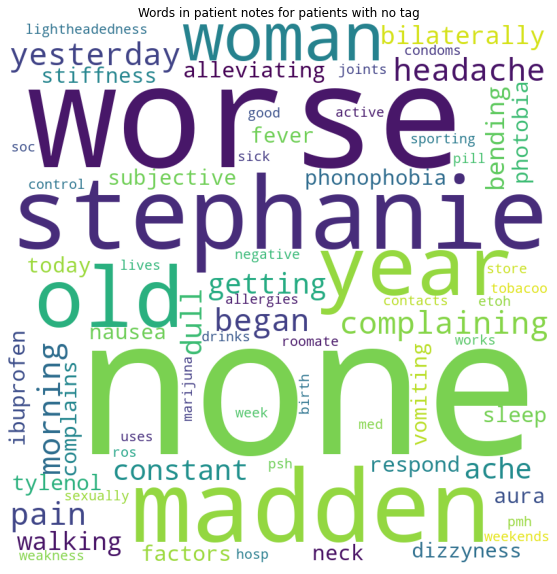

In [47]:
# Creating a column to indicate patient history without any annotation tag
#df2["tags_female"]= [1 if "female" in tgs.split(',') else 0 for tgs in df2.annotation]

# creating a corpus for movies with murder tag
word_cloud=""
for pn_hist in df2[df2["annotation"]==""].pn_history:
    word_cloud = pn_hist + " "

from wordcloud import WordCloud

#building a wordcloud
wordcloud = WordCloud(width=800, height=800, collocations=False,
background_color="white").generate(word_cloud)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.title("Words in patient notes for patients with no tag")
plt.axis("off")
plt.show()

In [48]:
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import Dense, Dropout, Activation, Concatenate
from tensorflow.keras.models import Model
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline

In [49]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)


REPLICAS:  1


In [50]:
df2.head()
df2['pn_history'].apply(lambda x:len(str(x).split())).max()

180

In [51]:
df2.head()
df2['feature_text'].apply(lambda x:len(str(x).split())).max()

12

In [52]:
from sklearn.model_selection import train_test_split
xtrain, xvalid, ytrain, yvalid = train_test_split(df2[['pn_history','feature_text']], df2['annotation'], 
                                                  random_state=42, 
                                                  test_size=0.3)

In [53]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit(df2.annotation.values)
ytrain=lbl_enc.transform(ytrain)
yvalid=lbl_enc.transform(yvalid)

In [54]:
ytrain

array([   0, 1361, 2632, ...,    0, 3597,    0])

In [55]:
print(xtrain.shape)
print(xvalid.shape)
print(ytrain.shape)
print(yvalid.shape)

(10010, 2)
(4290, 2)
(10010,)
(4290,)


In [56]:
from tensorflow.keras.preprocessing import sequence, text
token=text.Tokenizer(num_words=None)
max_len=200

In [57]:
token.fit_on_texts(list(df2['pn_history']) + list(df2['feature_text']))

In [58]:
xtrainph_seq = token.texts_to_sequences(xtrain['pn_history'])
xtrainft_seq = token.texts_to_sequences(xtrain['feature_text'])

In [59]:
xtrain['feature_text'][:1]

2981    no premenstrual symptoms
Name: feature_text, dtype: object

In [60]:
print(len(xtrainph_seq[0]))
print(len(xtrainft_seq[0]))

145
3


In [61]:
xvalidph_seq = token.texts_to_sequences(xvalid['pn_history'])
xvalidft_seq = token.texts_to_sequences(xvalid['feature_text'])

In [62]:
xvalid['feature_text'][:1]

4454    awakens at night
Name: feature_text, dtype: object

In [63]:
print(len(xvalidph_seq[0]))
print(len(xvalidft_seq[0]))

141
3


In [64]:
#zero pad the sequences
xtrainph_pad = sequence.pad_sequences(xtrainph_seq, maxlen=200)
xvalidph_pad = sequence.pad_sequences(xvalidph_seq, maxlen=200)

xtrainft_pad = sequence.pad_sequences(xtrainft_seq, maxlen=200)
xvalidft_pad = sequence.pad_sequences(xvalidft_seq, maxlen=200)

In [65]:
print(len(xtrainph_pad[0]))
print(len(xvalidph_pad[0]))

print(len(xtrainft_pad[0]))
print(len(xvalidft_pad[0]))

200
200
200
200


In [66]:
len(df2.annotation.unique())

4732

In [67]:
xtrainft_pad[0].shape

(200,)

In [68]:
word_index = token.word_index
len(word_index)

6487

In [69]:
from keras import backend as K
from sklearn.metrics import f1_score

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1_mic(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')



In [70]:
%%time
with strategy.scope():
    # A simpleRNN without any pretrained embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, 300,input_length=200))
    model.add(tf.keras.layers.Reshape((200,300),input_shape=(200, 1, 300)))
    model.add(SimpleRNN(256))
    model.add(Dense(4732, activation='softmax'))
    model.compile(optimizer='adam', metrics=[f1_m],loss='sparse_categorical_crossentropy')
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 300)          1946400   
                                                                 
 reshape (Reshape)           (None, 200, 300)          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 256)               142592    
                                                                 
 dense (Dense)               (None, 4732)              1216124   
                                                                 
Total params: 3,305,116
Trainable params: 3,305,116
Non-trainable params: 0
_________________________________________________________________
CPU times: user 191 ms, sys: 51.5 ms, total: 242 ms
Wall time: 380 ms


In [71]:
#model.fit(xtrainph_pad, ytrain, epochs=10, batch_size=64)

In [72]:
#prod_preds = model.predict(xvalidph_pad)


In [73]:
#len(prod_preds)

In [74]:
"""final_key=[]

for i in prod_preds:
    
    a=np.argmax(i)
    final_key.append(a)
    
print("Shape of valid Predicted table for Product column: ", len(final_key))"""


'final_key=[]\n\nfor i in prod_preds:\n    \n    a=np.argmax(i)\n    final_key.append(a)\n    \nprint("Shape of valid Predicted table for Product column: ", len(final_key))'

In [75]:
#final_key

In [76]:
"""%%time

embed_ph=Embedding(len(word_index) + 1, 300,input_length=200)(xtrainph_pad)
ph_out=SimpleRNN(100)(embed_ph)
ph_out=Dense(1, activation='relu')(ph_out)

embed_ft=Embedding(len(word_index) + 1, 300,input_length=200)(xtrainft_pad)
ft_out=SimpleRNN(100)(embed_ft)
ft_out=Dense(1, activation='relu')(ft_out)
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

concat= Concatenate(axis=-1)([ph_out,ft_out])
final_out=Dense(4732, activation='softmax')(concat)

model = Model(inputs=[xtrainph_pad, xtrainft_pad], outputs=final_out)
model.compile(loss='log', optimizer='adam', metrics=['f1_micro'])
print(model.summary())
    """

"%%time\n\nembed_ph=Embedding(len(word_index) + 1, 300,input_length=200)(xtrainph_pad)\nph_out=SimpleRNN(100)(embed_ph)\nph_out=Dense(1, activation='relu')(ph_out)\n\nembed_ft=Embedding(len(word_index) + 1, 300,input_length=200)(xtrainft_pad)\nft_out=SimpleRNN(100)(embed_ft)\nft_out=Dense(1, activation='relu')(ft_out)\n#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])\n\nconcat= Concatenate(axis=-1)([ph_out,ft_out])\nfinal_out=Dense(4732, activation='softmax')(concat)\n\nmodel = Model(inputs=[xtrainph_pad, xtrainft_pad], outputs=final_out)\nmodel.compile(loss='log', optimizer='adam', metrics=['f1_micro'])\nprint(model.summary())\n    "

In [77]:
#xtrainph_pad[0]
#xtrain_seq[0]

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.compose import ColumnTransformer



In [79]:
# TF-IDF on patient history and features
vectorizer1 = TfidfVectorizer(max_features=500,min_df=0.00009, smooth_idf=True,tokenizer = lambda x: x.split(' '), 
                        lowercase=True, analyzer='word',ngram_range=(1,3))
vectorizer2 = TfidfVectorizer(max_features=500,min_df=0.00009, smooth_idf=True,tokenizer = lambda x: x.split(' '), 
                        lowercase=True, analyzer='word',ngram_range=(1,3))
column_transformer = ColumnTransformer(
    [('tfidf1', vectorizer1, 'pn_history'), 
    ('tfidf2', vectorizer2, 'feature_text')],
    remainder='passthrough')





# count vectorizer on patient history and features

c_vectorizer1 = CountVectorizer(max_features=500,min_df=0.00009, tokenizer = lambda x: x.split(' '), 
                        lowercase=True, analyzer='word',ngram_range=(1,3))
c_vectorizer2 = CountVectorizer(max_features=500,min_df=0.00009, tokenizer = lambda x: x.split(' '), 
                        lowercase=True, analyzer='word',ngram_range=(1,3))
column_transformer_cv = ColumnTransformer(
    [('tfidf1', c_vectorizer1, 'pn_history'), 
    ('tfidf2', c_vectorizer2, 'feature_text')],
    remainder='passthrough')

In [80]:
tf_train_data = df2[['pn_history','feature_text']]

tf_test_data = test_df2[['pn_history','feature_text']]


In [81]:
#Keeping the most trusted vectrizor
X=column_transformer.fit_transform(tf_train_data)
X_test=column_transformer.transform(tf_test_data)



In [82]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)

TfidfTransformer()

In [83]:
X

<14300x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1463256 stored elements in Compressed Sparse Row format>

In [84]:
X_test

<5x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 504 stored elements in Compressed Sparse Row format>

I am not sure about the below hyper parameters

In [85]:
#abc

In [86]:
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.decomposition import TruncatedSVD
svd = decomposition.TruncatedSVD(n_components=120)
svd.fit(X)
X = svd.transform(X)
X_test = svd.transform(X_test)

In [87]:
X

array([[ 0.79035069, -0.13274038, -0.15756775, ...,  0.04760755,
         0.06778115, -0.00945337],
       [ 0.7857479 , -0.12694237, -0.15497754, ..., -0.18676222,
        -0.11620404,  0.02817619],
       [ 0.76681442, -0.10215976, -0.15187683, ...,  0.00662641,
         0.05351413, -0.01600459],
       ...,
       [ 0.8107997 , -0.07407601, -0.0899316 , ..., -0.02519659,
        -0.00807307, -0.0161926 ],
       [ 0.82477944, -0.0896716 , -0.09668003, ..., -0.01629712,
        -0.01201381, -0.01470843],
       [ 0.81499301, -0.08316265, -0.11325385, ..., -0.0054825 ,
        -0.01984001, -0.04848742]])

In [88]:
scl = preprocessing.StandardScaler()
scl.fit(X)
X = scl.transform(X)
X_test = scl.transform(X_test)

In [89]:
X.shape

(14300, 120)

In [90]:
X_test.shape

(5, 120)

In [91]:
X.dtype

dtype('float64')

In [92]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(df2.annotation.values)

In [93]:
y

array([ 916, 2744,  835, ..., 3559, 3141, 4102])

In [94]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV

# Fitting a simple SVM



#classifier = OneVsRestClassifier(SGDClassifier(loss="log", alpha=1e-5, penalty="l1"), n_jobs=-1)
classifier = LogisticRegression(penalty='l2',C=0.1)
#classifier = SVC(C=1.0, probability=True)
#classifier = XGBClassifier(max_depth=5, n_estimators=50,subsample=0.8, learning_rate=0.1, verbosity=1)
#classifier = MultinomialNB()
#classifier = GaussianNB()

In [95]:
# Initialize SVD
#svd = TruncatedSVD()
    
# Initialize the standard scaler 
#scl = preprocessing.StandardScaler()

# We will use logistic regression here..
#lr_model = LogisticRegression()

# Create the pipeline 
#clf = pipeline.Pipeline([('svd', svd), ('scl', scl), ('lr', lr_model)])

In [96]:
#param_grid = {'svd__n_components' : [120, 180],'lr__C': [0.1, 1.0, 10], 'lr__penalty': ['l1', 'l2']}

In [97]:
# Initialize Grid Search Model
#model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='f1_micro',verbose=10, n_jobs=-1, refit=True, cv=2)

# Fit Grid Search Model
#model.fit(X, df2["annotation"])  # we can use the full data here but im only using xtrain
#print("Best score: %0.3f" % model.best_score_)
#print("Best parameters set:")
#best_parameters = model.best_estimator_.get_params()
#for param_name in sorted(param_grid.keys()):
 #   print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [98]:
#classifier.fit(X.toarray(), y)


In [99]:

scores = cross_val_score(classifier, X, df2['annotation'], cv=5, scoring='f1_micro')

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org

In [100]:
np.average(scores)

0.2923076923076923

In [101]:
classifier.fit(X, df2['annotation'])
pred_annot=classifier.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [102]:
#pred_annot_2=classifier.predict(X.toarray())

In [103]:
#pred_annot_2

In [104]:
#pred_annot[14279:14300]
pred_annot

array(['', '', 'chest pressure', '', ''], dtype=object)

In [105]:
#df2['annotation'].tail(20)
df2['annotation'].head()

0            dad with recent heart attcak
1               mom with "thyroid disease
2                          chest pressure
3          intermittent episodes; episode
4    felt as if he were going to pass out
Name: annotation, dtype: object

In [106]:
sub = pd.DataFrame(pred_annot, columns=['annotation'])
sub['id']=test_df2['id']
sub['pn_history']=test_df2['pn_history']

In [107]:
#sub_train = pd.DataFrame(pred_annot_2, columns=['annotation'])
#sub_train['id']=df2['id']
#sub_train['pn_history']=df2['pn_history']
#sub_train['feature_text']=df2['feature_text']
#sub_train.head(10)

In [108]:
sub.shape

(5, 3)

In [109]:
sub.head()

,annotation,id,pn_history
0,,00016_000,hpi 17yo m presents with palpitations patien...
1,,00016_001,hpi 17yo m presents with palpitations patien...
2,chest pressure,00016_002,hpi 17yo m presents with palpitations patien...
3,,00016_003,hpi 17yo m presents with palpitations patien...
4,,00016_004,hpi 17yo m presents with palpitations patien...


In [110]:
#abc

In [111]:
def span_loc(x,pn_hist):
    k=x.split('; ')
    k_size=len(k)
    res=''
    last_index=0
    if(x==''):
        res=''
    else:
        for i in range (k_size):
            #print(k[i])
            #sp = re.search(k[i], df2.pn_history[j][last_index:])
            sp = re.search(k[i],pn_hist[last_index:] )
            if(sp):
                span_str=last_index+int(sp.start())
                span_end=last_index+int(sp.end())
                res=res+str(span_str)+' '+str(span_end)+';'
                last_index=sp.end()
                #print(str("1st loop")+' '+str(last_index)+ " "+res)
            else:
                #print(k[i])
                m=k[i].split(' ')
                
                span2=''
                span1=''
                begin=0
                for t in range(len(m)):
                    #print(' '.join(m[len(m)-1-t:]))
                    sp2=re.search(' '.join(m[len(m)-1-t:]), pn_hist[last_index:])
                    if(sp2):
                        
                        span_str=last_index+int(sp2.start())
                        span_end=last_index+int(sp2.end())
                        span2=str(span_str)+' '+str(span_end)
                        #print(span_str)
                        #print(span_end)
                        #print(span2)
                        last_index=span_end
                        begin=span_str
                        #print(str("2nd loop")+' '+str(' '.join(m[len(m)-1-t:]))+' '+str(last_index)+ " "+span2 + str(begin))
                    else:
                        break
                #print(pn_hist[:begin])        
                sp3=re.search(' '.join(m[:len(m)-t]), pn_hist[:begin])  
                #print(sp3)
                if(sp3):
                    span_str=int(sp3.start())
                    span_end=int(sp3.end())
                    span1=str(span_str)+' '+str(span_end)+';'
                    
                if(span1!='' and span2!=''):
                    res=res+span1+span2+';'
                #print(str("2nd loop part 2")+' '+str(last_index)+ " "+span1 + res)
                
    return(res[:-1])    
    

In [112]:
df2["annotation"][3144]

'previously regular; previously 5 days; previously  28 29 days'

In [113]:
#sub_train["annotation"][3144]

In [114]:
#sub_train["pn_history"][1319]

In [115]:
#span=span_loc(sub_train["annotation"][3144],sub_train["pn_history"][3144])
#span

In [116]:
span=span_loc(sub["annotation"][3],sub["pn_history"][3])
span

''

In [117]:
sub["location"]=sub.apply(lambda row : span_loc(sub["annotation"][row.name],sub["pn_history"][row.name]),axis=1)

In [118]:
#sub_train["location"]=sub_train.apply(lambda row : span_loc(sub_train["annotation"][row.name],sub_train["pn_history"][row.name]),axis=1)

In [119]:
#sub_train.head()

In [120]:
#sub_train.to_csv("submission_train.csv", index = False)

In [121]:
sub.head()

,annotation,id,pn_history,location
0,,00016_000,hpi 17yo m presents with palpitations patien...,
1,,00016_001,hpi 17yo m presents with palpitations patien...,
2,chest pressure,00016_002,hpi 17yo m presents with palpitations patien...,203 217
3,,00016_003,hpi 17yo m presents with palpitations patien...,
4,,00016_004,hpi 17yo m presents with palpitations patien...,


In [122]:
sub_final=sub[["id","location"]]

In [123]:
sample_sub.head()

,id,location
0,00016_000,0 100
1,00016_001,NaN
2,00016_002,200 250;300 400
3,00016_003,NaN
4,00016_004,75 110


In [124]:
sub_final.head()

,id,location
0,00016_000,
1,00016_001,
2,00016_002,203 217
3,00016_003,
4,00016_004,


**Remove it asap after use**

In [125]:
#sub_final["location"]='1 3'

In [126]:
sub_final.head()

,id,location
0,00016_000,
1,00016_001,
2,00016_002,203 217
3,00016_003,
4,00016_004,


In [127]:
sub_final.to_csv("submission.csv", index = False)

In [128]:
pd.read_csv("submission.csv")

,id,location
0,00016_000,NaN
1,00016_001,NaN
2,00016_002,203 217
3,00016_003,NaN
4,00016_004,NaN


In [129]:
sub_final.location.loc[2]

'203 217'

In [130]:
sub_final.dtypes

id          object
location    object
dtype: object

In [131]:
sub_final.shape

(5, 2)

In [132]:
sub_final.isnull().sum()

id          0
location    0
dtype: int64

In [133]:
import numpy as np
import pandas as pd
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [136]:
import pickle as pkl
pkl.dump(classifier,open("final_model.p","wb"))

In [137]:
import sklearn
sklearn_version = sklearn.__version__
print(sklearn_version)

1.0.2


In [138]:
!pip install streamlit
!pip install pyngrok===4.1.1
from pyngrok import ngrok

     |████████████████████████████████| 10.1 MB 7.4 MB/s 
     |████████████████████████████████| 181 kB 40.6 MB/s 
     |████████████████████████████████| 4.3 MB 56.7 MB/s 
     |████████████████████████████████| 111 kB 37.3 MB/s 
     |████████████████████████████████| 164 kB 43.9 MB/s 
     |████████████████████████████████| 76 kB 4.8 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 130 kB 72.7 MB/s 
     |████████████████████████████████| 793 kB 46.3 MB/s 
     |████████████████████████████████| 130 kB 55.2 MB/s 
     |████████████████████████████████| 428 kB 57.0 MB/s 
     |████████████████████████████████| 381 kB 56.2 MB/s 
  Created wheel for blinker: filename=blinker-1.4-py3-none-any.whl size=13478 sha256=c744252a2f3c591adc066fb9bd026cdb51747a9ed9b9c4c24d243c47e1d8611a
  Stored in directory: /root/.cache/pip/wheels/22/f5/18/df711b66eb25b21325c132757d4314db9ac5e8dabeaf196eab
Successfully built blinker
  Attempting uninstall: 

  Created wheel for pyngrok: filename=pyngrok-4.1.1-py3-none-any.whl size=15983 sha256=31a1a0291f43492540246559c69a4ed48209e5e5e87c1053c71758fc3fd3851f
  Stored in directory: /root/.cache/pip/wheels/b1/d9/12/045a042fee3127dc40ba6f5df2798aa2df38c414bf533ca765
Successfully built pyngrok


In [140]:
%%writefile NBME-health-app.py
import streamlit as st
import base64
import sklearn
import numpy as np
import pickle as pkl
from sklearn.preprocessing import MinMaxScaler
scal=MinMaxScaler()

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.compose import ColumnTransformer
vectorizer1 = TfidfVectorizer(max_features=500,min_df=0.00009, smooth_idf=True,tokenizer = lambda x: x.split(' '), 
                        lowercase=True, analyzer='word',ngram_range=(1,3))
vectorizer2 = TfidfVectorizer(max_features=500,min_df=0.00009, smooth_idf=True,tokenizer = lambda x: x.split(' '), 
                        lowercase=True, analyzer='word',ngram_range=(1,3))
column_transformer = ColumnTransformer(
    [('tfidf1', vectorizer1, 'pn_history'), 
    ('tfidf2', vectorizer2, 'feature_text')],
    remainder='passthrough')

#Load the saved model
model=pkl.load(open("final_model.p","rb"))



st.set_page_config(page_title="NBME Health App",page_icon="⚕️",layout="centered",initial_sidebar_state="expanded")



def preprocess(patient_note,feature_text):   
 
    
    df1=pd.DataFrame({'pn_history':patient_note,'feature_text':feature_text})
    df1['feature_text']=df1['feature_text'].str.replace("-OR-", "; ").str.replace("-", " ")
    df1['pn_history']=df1['pn_history'].str.translate ({ord(c): " " for c in "!@#$%^&*()[]{}:,./<>?\|`~-=_+"})

    df1['pn_history']=df1['pn_history'].apply(lambda x: x.lower())
    df1['feature_text']=df1['feature_text'].apply(lambda x: x.lower())

    user_input=column_transformer.transform(df1)
    prediction = model.predict(user_input)

    return prediction



st.title("NBME keyword prediction")
html_temp = """
    <div style="background-color:tomato;padding:10px">
    <h2 style="color:white;text-align:center;">Streamlit Bank Authenticator ML App </h2>
    </div>
    """
st.markdown(html_temp,unsafe_allow_html=True)
patient_note = st.text_input("patient_note","Type Here")
feature_text = st.text_input("feature_text","Type Here")    



pred=preprocess(patient_note,feature_text)


if st.button("Predict"):
  st.success('The output is {}'.format(pred))
    
st.sidebar.subheader("About App")

st.sidebar.info("This web app is helps you to find out whether you are at a risk of developing a heart disease.")
st.sidebar.info("Enter the required fields and click on the 'Predict' button to check whether you have a healthy heart")
st.sidebar.info("Don't forget to rate this app")



feedback = st.sidebar.slider('How much would you rate this app?',min_value=0,max_value=5,step=1)

if feedback:
  st.header("Thank you for rating the app!")
  st.info("Caution: This is just a prediction and not doctoral advice. Kindly see a doctor if you feel the symptoms persist.") 


     

Writing NBME-health-app.py


In [141]:
!nohup streamlit run NBME-health-app.py &
url = ngrok.connect(port='8501')
url

nohup: appending output to 'nohup.out'


'http://3af1-34-125-137-178.ngrok.io'